In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load the pre-trained VGG19 model
vgg19_base = VGG19(weights='imagenet',
                   include_top=False,
                   input_shape=(224, 224, 3)) 

In [3]:
 # Freeze the weights of all layers in the VGG19 base model
for layer in vgg19_base.layers:
    layer.trainable = False 

In [4]:
num_classes = 15 #yeh jitni class banegi utni kariyo
batch_size = 32
num_epochs = 25 #isko 30 kardiyo

In [5]:
# Create the new model by adding the last convolution block and fully connected layers
from tensorflow.keras import models
from tensorflow.keras import layers
x = vgg19_base.output
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(4096, activation='relu')(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

In [6]:
# Train only the last few layers of the model with your own data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'split_data/train/',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 5536 images belonging to 15 classes.


In [7]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        'split_data/val',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 686 images belonging to 15 classes.


In [8]:
# Compile the model
model = models.Model(inputs=vgg19_base.input, outputs=predictions)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Train the model
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size)

Epoch 1/25
173/173 [==============================] - 1177s 7s/step - loss: 2.1225 - accuracy: 0.2578 - val_loss: 1.8744 - val_accuracy: 0.3333
Epoch 2/25
173/173 [==============================] - 1122s 6s/step - loss: 1.6825 - accuracy: 0.4180 - val_loss: 1.6985 - val_accuracy: 0.4062
Epoch 3/25
173/173 [==============================] - 1113s 6s/step - loss: 1.4775 - accuracy: 0.4984 - val_loss: 1.4872 - val_accuracy: 0.4955
Epoch 4/25
173/173 [==============================] - 1113s 6s/step - loss: 1.3172 - accuracy: 0.5605 - val_loss: 1.4343 - val_accuracy: 0.5149
Epoch 5/25
173/173 [==============================] - 1104s 6s/step - loss: 1.2070 - accuracy: 0.6006 - val_loss: 1.3956 - val_accuracy: 0.5432
Epoch 6/25
173/173 [==============================] - 1107s 6s/step - loss: 1.1206 - accuracy: 0.6326 - val_loss: 1.2965 - val_accuracy: 0.5893
Epoch 7/25
173/173 [==============================] - 1111s 6s/step - loss: 1.0404 - accuracy: 0.6564 - val_loss: 1.2778 - val_accuracy:

In [10]:
from sklearn.metrics import label_ranking_average_precision_score, top_k_accuracy_score
from keras.utils import to_categorical

# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'split_data/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Make predictions on the test set
y_pred = model.predict(test_generator)

# Compute LWLRAP score
y_true = to_categorical(test_generator.labels, num_classes=15)
lwlrAP = label_ranking_average_precision_score(y_true, y_pred)
print('LWLRAP score:', lwlrAP)

# Compute top-5 categorical accuracy
top5_accuracy = top_k_accuracy_score(test_generator.labels, y_pred, k=5)
print('Top-5 categorical accuracy:', top5_accuracy)

Found 706 images belonging to 15 classes.
23/23 [==============================] - 93s 4s/step - loss: 0.9171 - accuracy: 0.6983
Test Loss: 0.9171121120452881
Test Accuracy: 0.698300302028656
23/23 [==============================] - 117s 5s/step
LWLRAP score: 0.8114052299604707
Top-5 categorical accuracy: 0.9560906515580736


In [10]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'history' is not defined

In [11]:
import numpy as np

# Get the true positive, false positive, true negative, and false negative values
y_true = test_generator.labels
y_pred = np.argmax(y_pred, axis=1)
tp = np.sum((y_true == 1) & (y_pred == 1))
fp = np.sum((y_true == 0) & (y_pred == 1))
tn = np.sum((y_true == 0) & (y_pred == 0))
fn = np.sum((y_true == 1) & (y_pred == 0))

# Calculate precision, recall, and F1 score
precision = tp / (tp + fp + 1e-7)  # Add a small epsilon to avoid division by zero
recall = tp / (tp + fn + 1e-7)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)


Precision: 0.9999999987341773
Recall: 0.9874999987656251
F1 Score: 0.9937106405759292


In [12]:
from sklearn.metrics import classification_report
import numpy as np

# Get predicted labels
y_pred = model.predict(test_generator)

# Convert predicted probabilities to labels
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Calculate precision, recall, and F1 score
print(classification_report(y_true, y_pred, target_names=class_names))


23/23 [==============================] - 230s 9s/step
                              precision    recall  f1-score   support

                    Apusapus       0.67      0.29      0.40         7
              Chlorischloris       0.84      0.70      0.76       113
Coccothraustescoccothraustes       0.61      0.81      0.69        21
             Columbapalumbus       0.78      0.74      0.76        53
            Corvusfrugilegus       0.67      0.80      0.73         5
             Delichonurbicum       0.00      0.00      0.00        11
            Dendrocoposmajor       0.67      0.33      0.44         6
               Motacillaalba       0.50      0.21      0.29        24
              Passermontanus       0.45      0.39      0.42        33
         Phoenicurusochruros       0.57      0.61      0.59        75
      Phoenicurusphoenicurus       0.66      0.80      0.72        90
       Phylloscopuscollybita       0.70      0.86      0.77       133
               Sittaeuropaea       

C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# Train the model
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size)

Epoch 1/20
173/173 [==============================] - 1063s 6s/step - loss: 2.1269 - accuracy: 0.2641 - val_loss: 1.8423 - val_accuracy: 0.3631
Epoch 2/20
173/173 [==============================] - 1089s 6s/step - loss: 1.7030 - accuracy: 0.4122 - val_loss: 1.6300 - val_accuracy: 0.4315
Epoch 3/20
173/173 [==============================] - 1088s 6s/step - loss: 1.4871 - accuracy: 0.5000 - val_loss: 1.5111 - val_accuracy: 0.4896
Epoch 4/20
173/173 [==============================] - 1080s 6s/step - loss: 1.3335 - accuracy: 0.5564 - val_loss: 1.4336 - val_accuracy: 0.5268
Epoch 5/20
173/173 [==============================] - 1083s 6s/step - loss: 1.2414 - accuracy: 0.5820 - val_loss: 1.3177 - val_accuracy: 0.5595
Epoch 6/20
173/173 [==============================] - 1087s 6s/step - loss: 1.1172 - accuracy: 0.6348 - val_loss: 1.2816 - val_accuracy: 0.5729
Epoch 7/20
173/173 [==============================] - 1088s 6s/step - loss: 1.0750 - accuracy: 0.6494 - val_loss: 1.2208 - val_accuracy:

In [10]:
from sklearn.metrics import label_ranking_average_precision_score, top_k_accuracy_score
from keras.utils import to_categorical

# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'split_data/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Make predictions on the test set
y_pred = model.predict(test_generator)

# Compute LWLRAP score
y_true = to_categorical(test_generator.labels, num_classes=15)
lwlrAP = label_ranking_average_precision_score(y_true, y_pred)
print('LWLRAP score:', lwlrAP)

# Compute top-5 categorical accuracy
top5_accuracy = top_k_accuracy_score(test_generator.labels, y_pred, k=5)
print('Top-5 categorical accuracy:', top5_accuracy)

Found 706 images belonging to 15 classes.
23/23 [==============================] - 92s 4s/step - loss: 1.0199 - accuracy: 0.6714
Test Loss: 1.019948124885559
Test Accuracy: 0.6713880896568298
23/23 [==============================] - 89s 4s/step
LWLRAP score: 0.7949873741304337
Top-5 categorical accuracy: 0.9504249291784702


In [9]:
# Train the model
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size)

Epoch 1/10
173/173 [==============================] - 1222s 7s/step - loss: 2.1233 - accuracy: 0.2625 - val_loss: 1.8426 - val_accuracy: 0.3423
Epoch 2/10
173/173 [==============================] - 1162s 7s/step - loss: 1.7136 - accuracy: 0.3976 - val_loss: 1.6699 - val_accuracy: 0.4479
Epoch 3/10
173/173 [==============================] - 1099s 6s/step - loss: 1.5182 - accuracy: 0.4798 - val_loss: 1.5405 - val_accuracy: 0.4836
Epoch 4/10
173/173 [==============================] - 1101s 6s/step - loss: 1.3435 - accuracy: 0.5517 - val_loss: 1.4092 - val_accuracy: 0.5476
Epoch 5/10
173/173 [==============================] - 1131s 7s/step - loss: 1.2272 - accuracy: 0.5932 - val_loss: 1.3647 - val_accuracy: 0.5744
Epoch 6/10
173/173 [==============================] - 1353s 8s/step - loss: 1.1226 - accuracy: 0.6326 - val_loss: 1.2702 - val_accuracy: 0.5804
Epoch 7/10
173/173 [==============================] - 1328s 8s/step - loss: 1.0558 - accuracy: 0.6543 - val_loss: 1.3028 - val_accuracy:

In [14]:
from sklearn.metrics import label_ranking_average_precision_score, top_k_accuracy_score
from keras.utils import to_categorical

# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'split_data/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Make predictions on the test set
y_pred = model.predict(test_generator)

# Compute LWLRAP score
y_true = to_categorical(test_generator.labels, num_classes=15)
lwlrAP = label_ranking_average_precision_score(y_true, y_pred)
print('LWLRAP score:', lwlrAP)

# Compute top-5 categorical accuracy
top5_accuracy = top_k_accuracy_score(test_generator.labels, y_pred, k=5)
print('Top-5 categorical accuracy:', top5_accuracy)

Found 706 images belonging to 15 classes.
23/23 [==============================] - 112s 5s/step - loss: 1.1242 - accuracy: 0.6062
Test Loss: 1.124183177947998
Test Accuracy: 0.6062322854995728
23/23 [==============================] - 105s 5s/step
LWLRAP score: 0.7493770983501867
Top-5 categorical accuracy: 0.9419263456090652


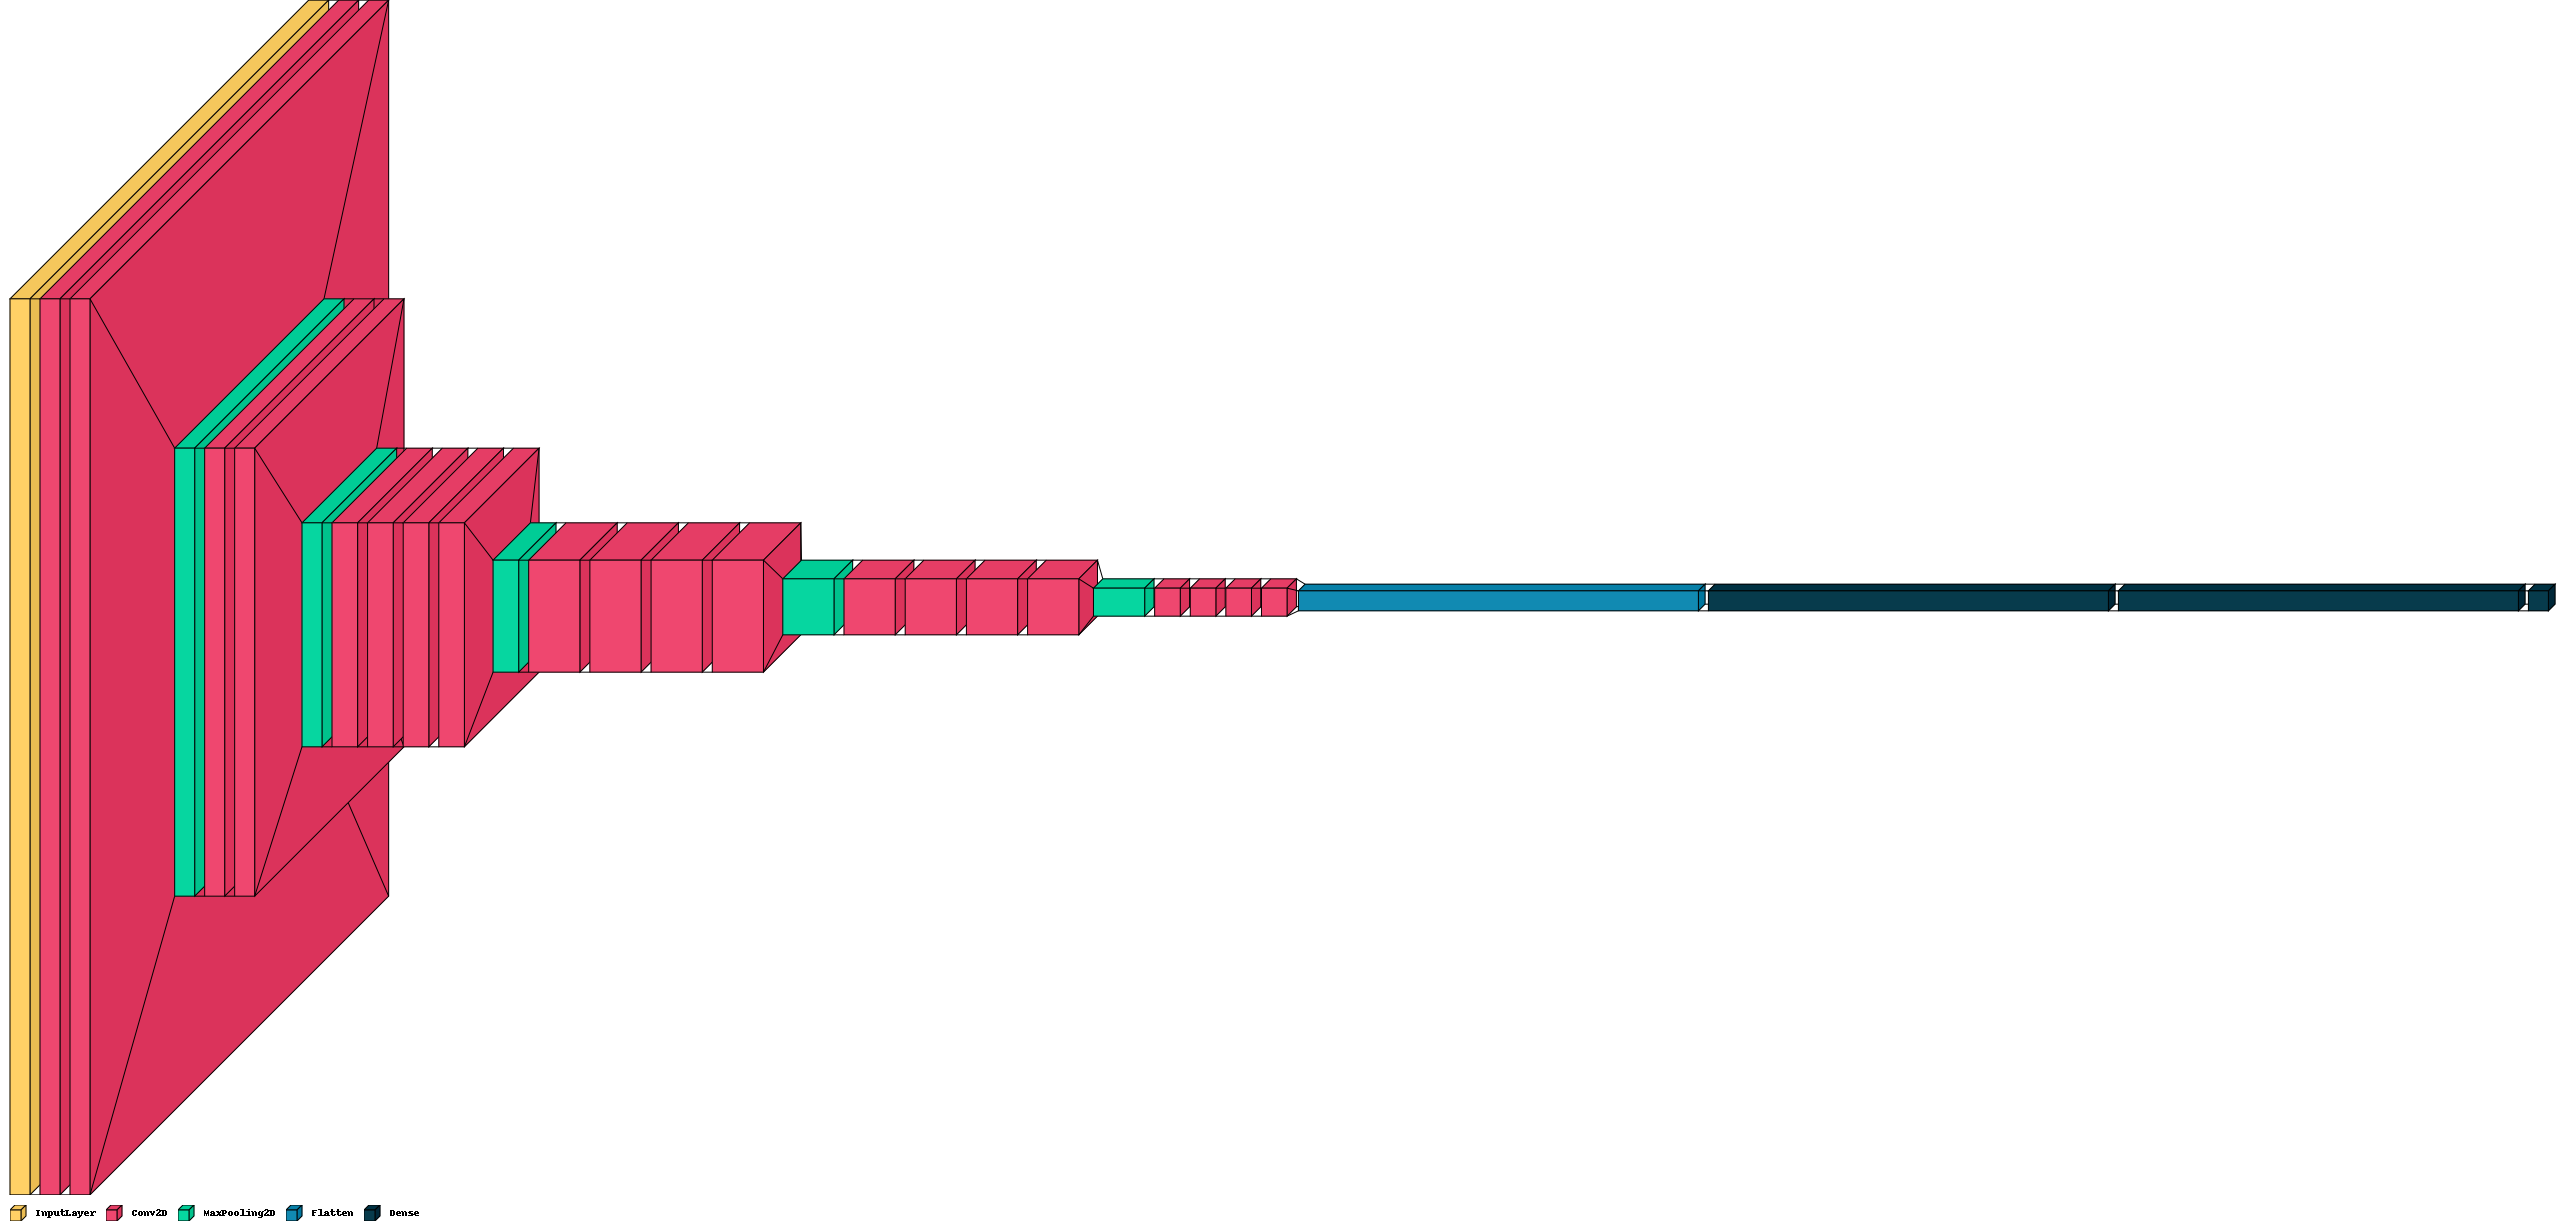

In [9]:
import visualkeras
from keras_visualizer import visualizer 

visualkeras.layered_view(model, legend=True) 
